In [1]:
from functions import *

In [220]:
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

# create new colormap
N = 256
vals = np.ones((N, 3))
color = 'tab:red'
rgb = np.array([220, 10, 10])/256
vals[:, 0] = np.linspace(1, rgb[0], N)
vals[:, 1] = np.linspace(1, rgb[1], N)
vals[:, 2] = np.linspace(1, rgb[2], N)
newcmp = ListedColormap(vals)

options = {
    'cmap': newcmp, 
    'norm': colors.LogNorm(vmin=9e-3, vmax=0.01)
}

In [201]:
n = 7
m = RandomIsingModel(n, seed=2)
print(m)

Ising model information:
Number of spins: 7
External fields (h): [-0.41675785 -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
  0.50288142]
Interaction matrix (J):
[[ 0.         -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
   0.50288142]
 [-0.05626683  0.         -0.90900761  0.55145404  2.29220801  0.04153939
  -1.11792545]
 [-2.1361961  -0.90900761  0.          1.17500122 -0.74787095  0.00902525
  -0.87810789]
 [ 1.64027081  0.55145404  1.17500122  0.         -0.23618403 -0.63765501
  -1.18761229]
 [-1.79343559  2.29220801 -0.74787095 -0.23618403  0.          0.1127265
   0.37044454]
 [-0.84174737  0.04153939  0.00902525 -0.63765501  0.1127265   0.
   0.77101174]
 [ 0.50288142 -1.11792545 -0.87810789 -1.18761229  0.37044454  0.77101174
   0.        ]]
Alpha: 0.44091116806551445
Ground state energy: -13.137807505121032
Ground state: |0110110> = |54>
Ground state degeneracy: 1



In [232]:
Q = get_proposal_mat_quantum_layden(m)

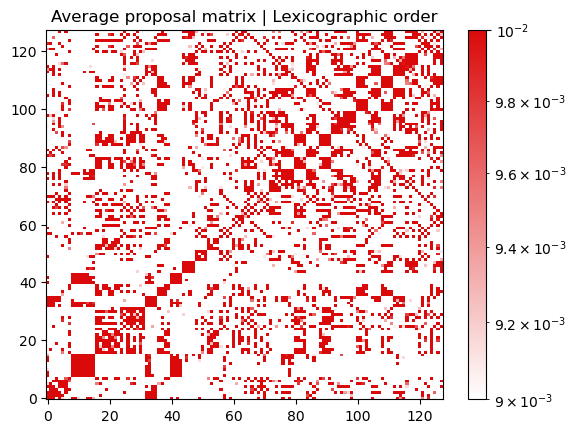

In [233]:
pc = plt.pcolor(np.arange(2**n), 
                np.arange(2**n), 
                Q,
                **options
                )
plt.colorbar(pc)
plt.title('Average proposal matrix | Lexicographic order')
plt.show()

# Sort by energy

In [234]:
sort_ids = np.argsort(m.E)
E_sorted = m.E[sort_ids]
Q_sorted = Q.copy()
Q_sorted = Q_sorted[sort_ids]
Q_sorted = Q_sorted[:, sort_ids]

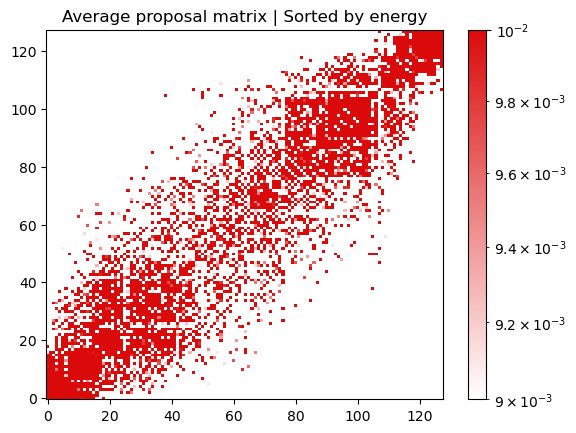

In [235]:
pc = plt.pcolor(np.arange(2**n), 
                np.arange(2**n), 
                Q_sorted,
                **options
                )
plt.colorbar(pc)
plt.title('Average proposal matrix | Sorted by energy')
plt.show()

# Entropies

In [236]:
entropies = np.zeros(2**n)
for i in range(2**n):
    entropies[i] = -sum(Q_sorted[i] * np.log2(Q_sorted[i], where=Q_sorted[i]>0, out=np.zeros_like(entropies)))

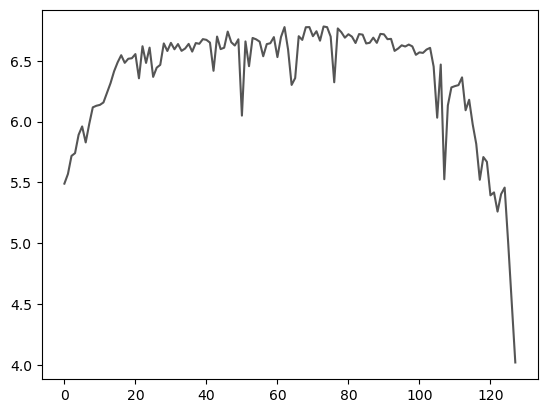

In [237]:
plt.plot(np.arange(2**n), entropies, color=dark_grey)
plt.show()

# Average Hamming distance